# Testing Data 

## Notebook Goal
It's unusual for testing and training data to have totally different datasets with totally different target variables. However, that is exactly what we are going to do. We are going to use the emotion classifiers and negativity classifier and test their ability to predict irrationality in a therapy session. So we gathered some publicly available transcripts of therapy sessions as well as some other potential data to test on. We'll have to clean them, as well as properly mark the target column. 


|Basic Description|Source|Variable Name|
|:---|:---|:---|
|A short back and forth between a therapist and client|[Interpretations of a Counselour in Training](http://counselingexaminer.org/counseling-transcription-interpretations-of-a-counselor-in-training/#more-2487)|couns_inter|
|A full therapy session with the therapist's commentary|[Cognitive Behavioral Therapy Transcript](https://www.psychotherapy.net/data/uploads/5113d623c0a74.pdf)|therapy_df|
|Examples of irrational and rational thoughts|[Put Together by Yisroel Len](https://docs.google.com/spreadsheets/d/1nbTu0bUTqk0kv-lAE-Yvt4aI8XSbaolIbv9mNpgkCII/edit?usp=sharing)|irrat_ex|

<table>
    <thead style="text-align:center">    
        <tr>
          <th>Mixed Anxiety Therapy Sessions</th>
          <th>Counseling Transcriptions</th>
          <th>Irrational Thoughts</th>
        </tr>
    </thead>
        <tr>
            <td><img src="../Images/mixed_anxiety.png" width="100%"/></td>
            <td><img src="../Images/short_session.png" width="100%"/></td>
            <td><img src="../Images/Irrational_thoughts.png" width="100%"/></td>
        </tr>
</table>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import regex as re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# The Short Transcription

In [2]:
# Read in the first dataset
couns_inter = pd.read_csv('../Data/Testing_Data/3_Uncleaned_Testing_Data/Example_Therapy_Session_Short.csv')

In [3]:
couns_inter.head()

,Text,Irrational
0,"Suzie: So, yesterday I get home after a long d...",0.0
1,NaN,NaN
2,Counselor: Wow.,NaN
3,"Suzie: That’s kinda like….. what I was like, I...",0.0
4,NaN,NaN


We constructed this data set using google spreadsheets and labeled the columns ourselves so we know that any column that contains NaNs we can drop. This will leave us with just the clients sentences.

In [4]:
couns_inter = couns_inter.dropna()

It looks like there was one we missed so we'll get rid of it here. We will also clean the data by getting rid of "Suzie:" at the begining of each sentence.

In [5]:
# remove "Suzie:" from the beginning of each sentence.
couns_inter['Text'] = couns_inter['Text'].map(lambda x: ' '.join([i for i in x.split() if i != 'Suzie:']))

In [6]:
# turn the numbers in the "Irrational" column into integers
couns_inter['Irrational'] = couns_inter['Irrational'].map(lambda x: int(x))

In [7]:
couns_inter.head()

,Text,Irrational
0,"So, yesterday I get home after a long day at w...",0
3,"That’s kinda like….. what I was like, I was li...",0
6,I did. I felt really exited and I was like…. I...,0
9,And I’m so flattered. I mean it wasn’t that bi...,0
12,It could have been any guy. It could have been...,0


The second data set is a text file which we are going to read, process and transform into a dataframe. So I'm going to need a couple of functions that i've used previously.

In [8]:
# We're going to use some of the functions that was used in cleaning the Training data.

# Instantiate Lemmatizer.
# Create a function to Lemmatize the words in each sentence and remove other unecessary characters.
def shorten(value):
    lemmatizer = WordNetLemmatizer()
    value = re.sub(r"http\S+", "", value)
    value = re.sub(r"http", "", value)
    letters_only = re.sub("[^a-zA-Z']", " ", value)
    return ' '.join([lemmatizer.lemmatize(word) for word in letters_only.lower().split()])

def vectorizer2000(X, y, max_features1=None, ngram_range1=(1, 1)):
    # Instantiate the vectorizer, and remove some unecessary words
    cvec = CountVectorizer(analyzer='word', stop_words='english', max_features=max_features1, ngram_range=ngram_range1)
    # Transform the data into something workable
    a = cvec.fit_transform(X)

    df = pd.DataFrame(a.toarray(), columns= cvec.get_feature_names())

    final_df = df.merge(y, how='outer', left_index=True, right_index=True)
    return final_df

# Function to remove the rows with float
def change_to_num(value):
    try:
        return int(value)
    except:
        return value
    
# Plotting functions

def pos_plotter(df, target_column, plot_title = 'Negativity Data Set', ylabel_title = 'The Most Commonly Occuring Words', xlabel_title = 'Number of Occurences'):
    eda_best = df[df[target_column] == 1].sum().sort_values(ascending=False).head(10)
    eda_best.drop(target_column, inplace=True)
    eda_best = eda_best[eda_best > 1]
    plt.figure(figsize=(8, 6))
    sns.barplot(y=eda_best.index, x=eda_best, palette='Reds_r')
    plt.title(plot_title,  fontweight='bold', fontsize=25)
    plt.ylabel(ylabel_title,  fontweight='bold', fontsize=20)
    plt.xlabel(xlabel_title,  fontweight='bold', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16);
    
    
def neg_plotter(df, target_column, plot_title = 'Positivity Data Set', ylabel_title = 'The Most Commonly Occuring Words', xlabel_title = 'Number of Occurences'):
    eda_worst = df[df[target_column] == 0].sum().sort_values(ascending=False).head(10)
#     eda_worst.drop(target_column, inplace=True)
    eda_worst = eda_worst[eda_worst > 1]
    plt.figure(figsize=(8, 6))
    sns.barplot(y=eda_worst.index, x=eda_worst, palette='Purples_r')
    plt.title(plot_title,  fontweight='bold', fontsize=25)
    plt.ylabel(ylabel_title,  fontweight='bold', fontsize=20)
    plt.xlabel(xlabel_title,  fontweight='bold', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16);

## The Longer Transcription

In [9]:
# Read in the file
f = open("../Data/Testing_Data/3_Uncleaned_Testing_Data/MixedAnxietyDepressionTesting2.txt", "r")

In [10]:
# Turn it into a Variable
psy_raw = f.read()

In [11]:
# Check out what it looks like
psy_raw[0:500]

'Meichenbaum: Anna—is it okay if I call you Anna?\nAnna: Oh, of course.\nMeichenbaum Commentary: Anna is 40, the mother of two children:\nJoseph, 17, and Lizzie, 13. Her husband, Patrick, is a lawyer, and Anna works\nfor an interior design company. She is referred by her physician because of\nrecurrent bouts of panic attacks with a history of depression.\nAnna: Lately I’ve been having these attacks that are keeping me from\nfunctioning. My heart starts racing. I feel like I’m suffocating, and I just\nfoc'

There are a number of things that need to get done, the easiest being the newline characters that will have to be gotten rid of so let's do that first.

In [12]:
psy_raw = psy_raw.replace('\n', " ")

Next, there are two main objectives: <br> 
1) Transform the back and forth between therapist and client into separate strings in a list. <br>
2) Drop all the non-client strings from the list.

In [13]:
# create a list based purely by spaces
psy_raw_list = psy_raw.split()

We want to create a list by splitting on these factors: `Meichenbaum:|Meichenbaum Commentary:|Anna:`. However, this will cause some issues because we will no longer be able to identify who's speaking. So for example if the text looked like this: `Meichenbaum: Anna—is it okay if I call you Anna? Anna: Oh, of course.Meichenbaum Commentary: Anna is 40, the mother of two children:Joseph, 17, and Lizzie, 13.` After splitting it would look like this: `["Anna—is it okay if I call you Anna?,",  "Oh, of course.", "Anna is 40, the mother of two children: Joseph, 17, and Lizzie, 13."]`. For some responses it won't be clear who's talking. So first we are going to create a separate identifying factor that will allow us to split on the factors mentioned in the first sentence of this paragraph and then single out the client's responses.

In [14]:
# Add an identifying factor to use when we split again which will determine who's talking
for i, sentence in enumerate(psy_raw_list):
    if sentence == 'Meichenbaum:':
        psy_raw_list[i] += ' 1'
    if sentence == 'Commentary:':
        psy_raw_list[i] += ' 2'
    if sentence == 'Anna:':
        psy_raw_list[i] += ' 3'
psy_raw_rejoin = ' '.join(psy_raw_list)

In [15]:
# Now we can split on those factors, strip the sentences of the identifying numbers and remove the empty strings
almost_list = [i.strip() for i in re.split('Meichenbaum:|Meichenbaum Commentary:|Anna:',psy_raw_rejoin) if i]
# Get rid of the identifying factor 
final_list = [i[2::] for i in almost_list if i[0] == '3']

In [16]:
# Transform into a dataframe
therapy_df = pd.DataFrame(final_list, columns=['Text'])

In [17]:
therapy_df.head()

,Text
0,"Oh, of course."
1,Lately I’ve been having these attacks that are...
2,"Well, it becomes a total preoccupation. I can’..."
3,"Patrick—that’s my husband—he was late, he lost..."
4,"Well, somehow I finally got myself together an..."


For this next part i'm going to export the data frame to google spreadsheets and label each sentence manually. Then I'll re-import it as a finished product. 
If you were wondering why I don't want to train my data on this it's because of how small it is but we CAN test our training data on it.

In [18]:
therapy_df.to_csv('../data/Testing_Data/4_Cleaned_Testing_Data/Long_Therapy_Session_Unlabeled.csv')

### Important Notes

1) While labeling the data I decided that even if a sentence contained an irrationality from someone else for example: "Bob, says that i'm a total failure" I will mark it as irrational even though the statement is likely true, because it might still be useful to the therapist to recognize that it contains an irrationality.

2) I know there is bias here due to the fact that I'm the only one labeling the data. So here's what we'll do to fix that. Since I lack the time right now to grab volunteers to label it, I'll make the following suggestion. Download this dataset and add a new column with your own labels.

In [19]:
therapy_df = pd.read_csv('../data/Testing_Data/4_Cleaned_Testing_Data/Long_Therapy_Session_Labeled.csv')

## Irrational Thought Examples

In [20]:
irrat_ex = pd.read_csv('../data/Testing_Data/3_Uncleaned_Testing_Data/CognitiveDistortions.csv')

In [21]:
irrat_ex.head()

,Distorted Thoughts,Irrational
0,I’m no good at sports; I just can’t do anything,1
1,“I have a zit on my nose; now I’m ugly; everyo...,1
2,“I passed because it was so easy,1
3,“I bet everyone is laughing at me,1
4,know I’m not going to be able to do this work,1


In [22]:
# Rename columns in order to concatenate
irrat_ex = irrat_ex.rename(columns = {'Distorted Thoughts': 'Text'})
# confirm that it worked
irrat_ex.head()

,Text,Irrational
0,I’m no good at sports; I just can’t do anything,1
1,“I have a zit on my nose; now I’m ugly; everyo...,1
2,“I passed because it was so easy,1
3,“I bet everyone is laughing at me,1
4,know I’m not going to be able to do this work,1


Let's put the previous datasets together with this one. They are examples of therapy sessions and other possible irrational thoughts that should work fine as testing data. Then we will do the basic cleaning.

In [23]:
final_df = pd.concat([therapy_df, couns_inter, irrat_ex])
final_df.head()

,Text,Irrational
0,"Oh, of course.",0
1,Lately I’ve been having these attacks that are...,0
2,"Well, it becomes a total preoccupation. I can’...",1
3,"Patrick—that’s my husband—he was late, he lost...",1
4,"Well, somehow I finally got myself together an...",1


In [40]:
# confirm that it worked
print(therapy_df.shape)
print(couns_inter.shape)
print(irrat_ex.shape)
print(final_df.shape)

(178, 2)
(21, 2)
(283, 2)
(482, 2)


In [24]:
# Basic cleaning
final_df['Text'] = final_df['Text'].apply(shorten)

In [25]:
# Save the final testing data 
final_df.to_csv('../data/Testing_Data/4_Cleaned_Testing_Data/Final_Testing_Data.csv')

In [26]:
X = final_df['Text']
y = final_df[['Irrational']]

In [41]:
final_df_cv = vectorizer2000(X, y, ngram_range1=(2, 2))

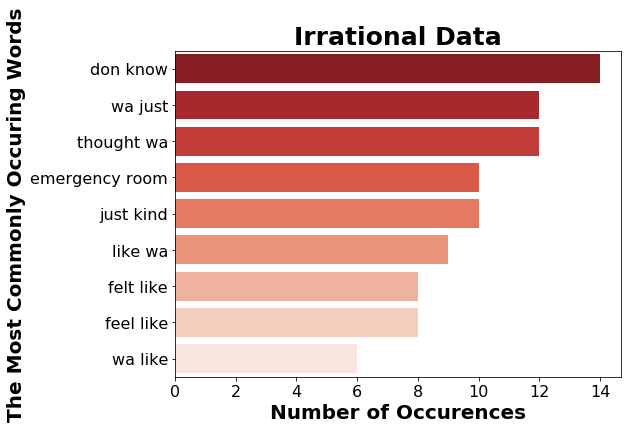

In [42]:
pos_plotter(final_df_cv, 'Irrational', 'Irrational Data')

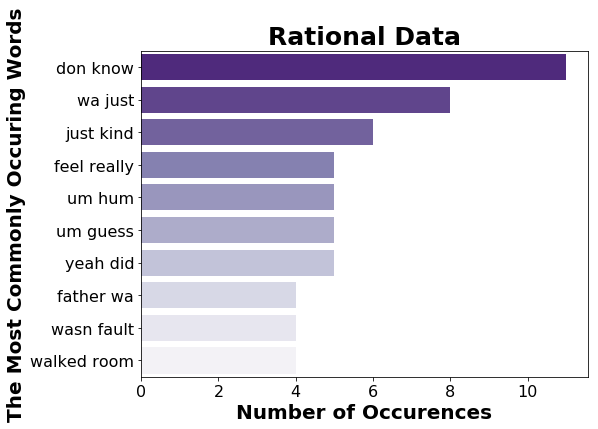

In [43]:
neg_plotter(final_df_cv, 'Irrational', 'Rational Data')

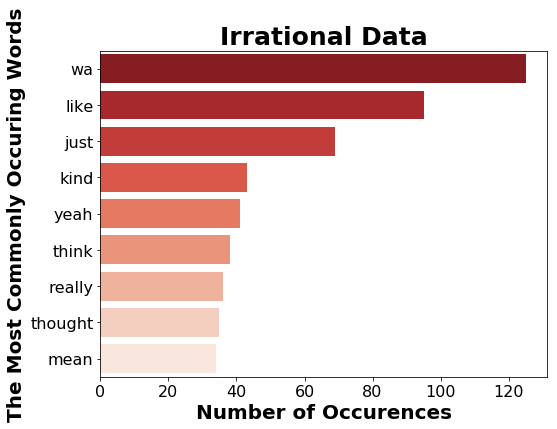

In [44]:
final_df_cv = vectorizer2000(X, y, ngram_range1=(1, 1))

pos_plotter(final_df_cv, 'Irrational', 'Irrational Data')

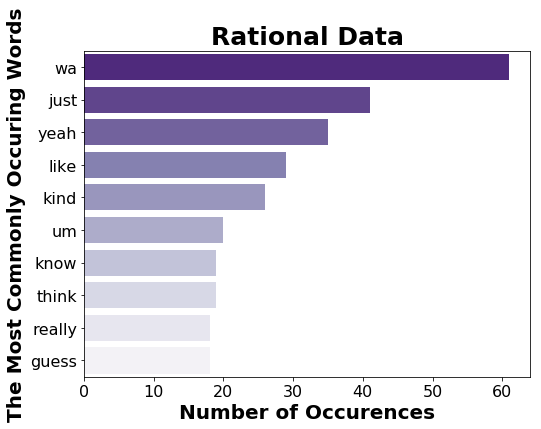

In [45]:
neg_plotter(final_df_cv, 'Irrational', 'Rational Data')

A lot of words here that don't seem to shed much light as to what is going on behind the scenes. It might be important to remove them later. But then again, this is a small data set so these words might not be so revealing.

Now on to the modelling stage.